In [4]:
import os
import os.path as osp
import scanpy as sc
import sys
import scipy.sparse as sp
import torch
import anndata

from sklearn.mixture import GaussianMixture
from anndata import AnnData
from warnings import filterwarnings

In [23]:
!pip list

Package                       Version
----------------------------- -----------
absl-py                       1.0.0
adjustText                    0.7.3
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
anndata                       0.8.0
annoy                         1.17.0
anyio                         3.5.0
argon2-cffi                   21.1.0
asgiref                       3.5.0
async-timeout                 4.0.1
attrs                         21.2.0
Babel                         2.9.1
backcall                      0.2.0
backports.zoneinfo            0.2.1
bamnostic                     1.1.8
BatchEval                     1.0.4
bbknn                         1.5.1
beautifulsoup4                4.11.1
biomart                       0.9.2
biopython                     1.69
bleach                        4.1.0
blessings                     1.7
cached-property               1.5.2
cachetools                    4.2.4
certifi           

In [2]:
filterwarnings("ignore")
sys.path.insert(0, "/media/Data/zhangchao/final_spatialign_version/v2/spatialign/eval")

In [3]:
from metrics import get_lisi, lisi_f1
from mclust import mclust

In [13]:
raw_list = [sc.read_h5ad(f) for f in [
            "/media/Data/zhangchao/final_spatialign_version/dataset/liver/sub_LC5Mbin35_raw.h5ad",
            "/media/Data/zhangchao/final_spatialign_version/dataset/liver/sub_LC20Mbin50_raw.h5ad"
        ]]

In [14]:
def pca_lowrank(data, q=50):
    x = data.X if not sp.issparse(data.X) else data.X.toarray()
    x_tensor = torch.tensor(x)
    u, x, v = torch.pca_lowrank(x_tensor, q=q)
    data.obsm["X_pca"] = torch.matmul(x_tensor, v).numpy()
    
def preprocess(data):
    data.var_names_make_unique()
    data.obs_names_make_unique()
    sc.pp.filter_cells(data, min_genes=20)
    sc.pp.filter_genes(data, min_cells=20)
    
def norm(data):
    sc.pp.normalize_total(data, target_sum=1e4)
    sc.pp.log1p(data)
    # sc.pp.scale(data)

In [15]:
for data in raw_list:
    preprocess(data)
    norm(data)

In [16]:
raw_merge = AnnData.concatenate(*raw_list)

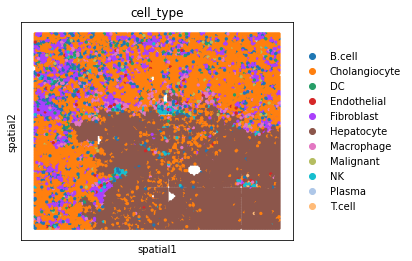

In [17]:
sc.pl.spatial(raw_list[0], color="cell_type", spot_size=2)

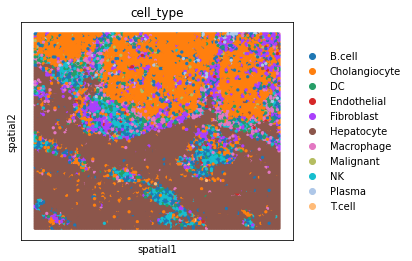

In [18]:
sc.pl.spatial(raw_list[1], color="cell_type", spot_size=2)

In [47]:
import pickle

In [48]:
data_dict = {"raw": raw_merge}

### hamony

In [19]:
harmony_data = raw_merge.copy()

In [20]:
pca_lowrank(harmony_data)

In [21]:
harmony_data

AnnData object with n_obs × n_vars = 35214 × 17773
    obs: 'x', 'y', 'cell_type', 'n_genes', 'batch'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'spatial', 'X_pca'

In [22]:
sc.external.pp.harmony_integrate(harmony_data, key="batch")

2024-01-03 15:54:08,346 - harmonypy - INFO - Iteration 1 of 10
2024-01-03 15:54:27,136 - harmonypy - INFO - Iteration 2 of 10
2024-01-03 15:54:44,024 - harmonypy - INFO - Iteration 3 of 10
2024-01-03 15:54:50,438 - harmonypy - INFO - Converged after 3 iterations


In [23]:
sc.pp.neighbors(harmony_data, use_rep="X_pca_harmony")
sc.tl.umap(harmony_data)

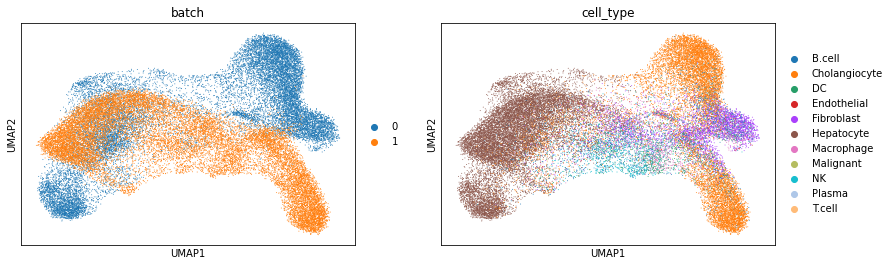

In [24]:
sc.pl.umap(harmony_data, color=["batch", "cell_type"])

In [49]:
data_dict["harmony"] = harmony_data

### combat

In [25]:
combat_data = raw_merge.copy()

In [26]:
sc.pp.combat(combat_data)

In [27]:
pca_lowrank(combat_data)

In [28]:
sc.pp.neighbors(combat_data, use_rep="X_pca")
sc.tl.umap(combat_data)

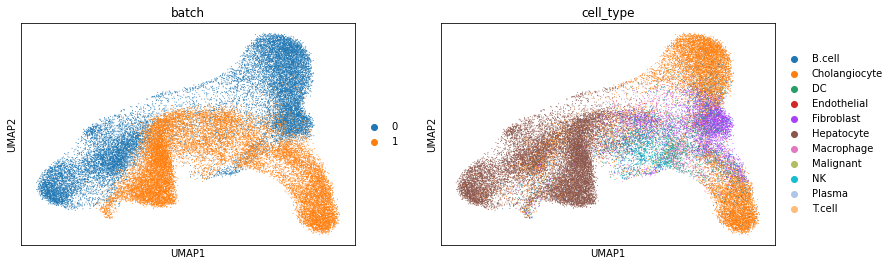

In [29]:
sc.pl.umap(combat_data, color=["batch", "cell_type"])

In [50]:
data_dict["combat"] = combat_data

### bbknn

In [30]:
bbknn_data = raw_merge.copy()

In [31]:
pca_lowrank(bbknn_data)

In [32]:
sc.external.pp.bbknn(bbknn_data)

In [33]:
sc.tl.umap(bbknn_data)

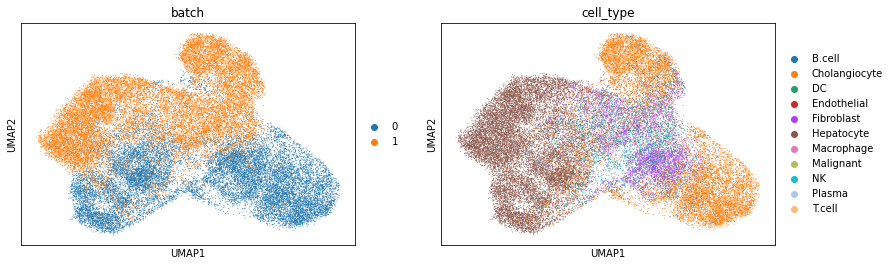

In [34]:
sc.pl.umap(bbknn_data, color=["batch", "cell_type"])

In [51]:
data_dict["bbknn"] = bbknn_data

### scanorama

In [35]:
import scanorama

In [36]:
scan_data = [raw_merge[raw_merge.obs["batch"]==c] for c in raw_merge.obs["batch"].cat.categories]

In [37]:
scan_correct = scanorama.correct_scanpy(scan_data, return_dimred=True)

Found 17773 genes among all datasets
[[0.         0.13553299]
 [0.         0.        ]]
Processing datasets (0, 1)


In [38]:
scan_corr = AnnData.concatenate(*scan_correct)

In [39]:
sc.pp.neighbors(scan_corr, use_rep="X_scanorama")
sc.tl.umap(scan_corr)

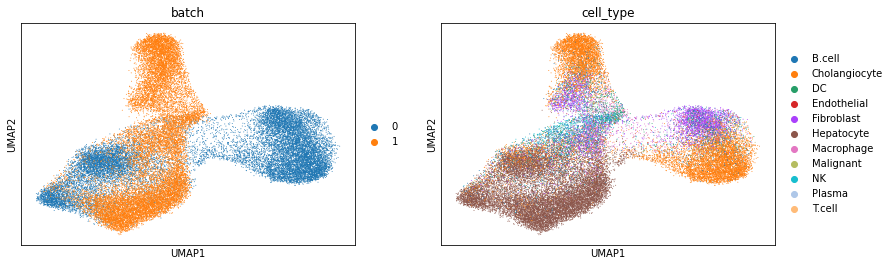

In [40]:
sc.pl.umap(scan_corr, color=["batch", "cell_type"])

In [52]:
data_dict["scanorama"] = scan_corr

### mnn

In [41]:
mnn_data = [raw_merge[raw_merge.obs["batch"]==c] for c in raw_merge.obs["batch"].cat.categories]

In [42]:
mnn_data, _, _ = sc.external.pp.mnn_correct(*mnn_data)

Performing cosine normalization...


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


In [43]:
mnn_data

AnnData object with n_obs × n_vars = 35214 × 17773
    obs: 'x', 'y', 'cell_type', 'n_genes', 'batch'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'spatial'

In [44]:
pca_lowrank(mnn_data)

In [45]:
sc.pp.neighbors(mnn_data)
sc.tl.umap(mnn_data)

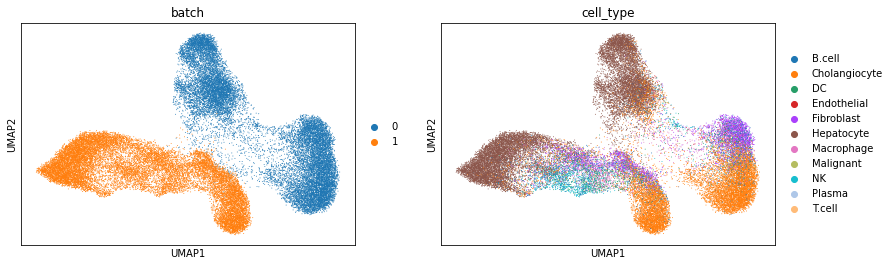

In [46]:
sc.pl.umap(mnn_data, color=["batch", "cell_type"])

In [53]:
data_dict["mnn"] = mnn_data

In [54]:
data_dict.keys()

dict_keys(['raw', 'harmony', 'combat', 'bbknn', 'scanorama', 'mnn'])

In [56]:
with open("liver_dict.pkl", "wb") as file:
    pickle.dump(data_dict, file)

In [57]:
os.getcwd()

'/media/Data/zhangchao/zhangchao/BatchEffectEvaluationPipeline/jupyter'